<a href="https://colab.research.google.com/github/Serafina-Z/opinion-analysis/blob/main/politics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Politics Opinion Analysis**

**Data Loading**

In [1]:
from google.colab import files
uploaded = files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download aashita/nyt-comments -f CommentsApril2017.csv -p /content/

 76% 41.0M/53.8M [00:00<00:00, 43.2MB/s]
100% 53.8M/53.8M [00:00<00:00, 84.2MB/s]


In [7]:
from zipfile import ZipFile
with ZipFile("CommentsApril2017.csv.zip", 'r') as zip:
  zip.extractall()

In [8]:
import pandas as pd
from collections import Counter
data = pd.read_csv("/content/CommentsApril2017.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
!pip install pandasql
from pandasql import sqldf
q1 = """
         select sectionName, articleID, commentBody, editorsSelection, recommendations
         from data
         where (sectionName = 'Politics')
"""

In [10]:
pysqldf = lambda q: sqldf(q, globals())
clean = pysqldf(q1)

In [11]:
clean.shape

(38381, 5)

In [12]:
len(Counter(clean["articleID"]).keys())

51

**Text Cleaning**

In [ ]:
!pip install nltk
import nltk
nltk.download("all")
from nltk import sent_tokenize
sentences = [] # each comment as a doc
for i in clean["commentBody"]:
    s=sent_tokenize(i)
    sentences.append(s)
sentences[0]

In [14]:
# tokenization
from nltk.tokenize import word_tokenize
token_list= []
for i in sentences: # i is comment level
    for j in i:
      tokens = word_tokenize(j)
      words = [word for word in tokens if word.isalpha()]
      words = [word.lower() for word in words]
      token_list.append(words)

In [15]:
# lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet 
lemmatizer = WordNetLemmatizer() 
def pos_tagger(nltk_tag): 
    if nltk_tag.startswith('J'): 
        return wordnet.ADJ 
    elif nltk_tag.startswith('V'): 
        return wordnet.VERB 
    elif nltk_tag.startswith('N'): 
        return wordnet.NOUN 
    elif nltk_tag.startswith('R'): 
        return wordnet.ADV 
    else:           
        return None
lemma_list = []
for i in token_list:
  pos_tagged = nltk.pos_tag(i)
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemma = [] 
  for word, tag in wordnet_tagged:
    if word == "i":
      continue
    if tag is None: 
      # if there is no available tag, append the token as is 
      lemma.append(word) 
    else:         
      # else use the tag to lemmatize the token 
      lemma.append(lemmatizer.lemmatize(word, tag))
  lemma_list.append(lemma)

**Aspect Extraction**

In [16]:
bi = []
for item in lemma_list:
  grams = [item[i:i+2] for i in range(len(item)-2+1)]
  bigrams = [' '.join(j) for j in grams]
  bi.append(bigrams)

In [17]:
bi_v = [bigram for i in bi for bigram in i]
uni_v = [unigram for i in lemma_list for unigram in i]

In [18]:
counter_bi = Counter(bi_v)

In [19]:
from nltk.corpus import stopwords

In [20]:
# filter before computing for less noise
for i in list(counter_bi.keys()):
  if i.split()[0] in stopwords.words('english'):
    if i.split()[1] in stopwords.words('english'):
      counter_bi.pop(i)

In [21]:
for i in list(counter_bi.keys()):
  w,t = nltk.pos_tag(i.split())[0]
  w1,t1 = nltk.pos_tag(i.split())[1]
  if t[0] != "N":
    if t1[0] != "N":
      counter_bi.pop(i)

In [22]:
import math
def pmi_index(bigram):
  a, b = bigram.split()
  new = []
  for i in bi_v:
    if i != bigram:
      for wor in i.split():
        new.append(wor)
    else:
      new.append(i)
  counter_new = Counter(new)
  if counter_new[a] == 0 or counter_new[b] == 0:
    pmi = "dependent"
  else:
    pmi = math.log(counter_new[bigram]/((counter_new[a]-counter_new[bigram])*(counter_new[b]-counter_new[bigram])/(len(new)-2*counter_new[bigram])))
  return pmi

In [23]:
counter_b = counter_bi.most_common(100)

In [24]:
bi_gram_list = [k for (k,v) in counter_b]

In [25]:
frequency = [v for (k,v) in counter_b]

In [26]:
pmi = [pmi_index(k) for (k,v) in counter_b]

In [27]:
fre_df = pd.DataFrame({"bigram":bi_gram_list, "pmi":pmi, "frequency": frequency})

In [28]:
fre_most = fre_df.sort_values(by="pmi", ascending=False).head(50)
fre_most

,bigram,pmi,frequency
28,http http,13.819215,825
9,supreme court,10.099670,1375
75,north korea,9.686748,495
3,white house,8.356377,1577
49,middle class,8.092947,655
45,united state,7.350041,666
21,health care,6.678027,1047
23,tax return,5.556808,974
71,tax reform,5.533427,509
25,donald trump,5.033974,905


In [29]:
select = fre_most.drop([28,86,63,62,40,29,34,31,66,7,89,95,50,59,48,93,33,64,11,2,20,54,1,41,33,18,81,37,85])
select_bi = select["bigram"] # 22 bigrams selected

In [30]:
len(select_bi)

22

In [31]:
from collections import defaultdict  
bi_dict = defaultdict(list)
for bi in select_bi:
  f,s = bi.split()
  bi_dict[f].append(s)

In [32]:
sent_c = []
for sent in lemma_list: 
  if len(sent) > 1:
    sent_list = []
    for i in range(len(sent)-1):
      if sent[i] in list(bi_dict.keys()):
        if sent[i+1] in bi_dict[sent[i]]:
          bi = sent[i] + " " + sent[i+1]
          sent_list.append(bi)
        else:
          if sent[i] not in stopwords.words('english'):
            sent_list.append(sent[i])  
      else:
        if sent[i] not in stopwords.words('english'):
          sent_list.append(sent[i]) 
    sent_c.append(sent_list)
  elif len(sent) == 1:
    if sent[0] not in stopwords.words('english'):
      sent_c.append(sent)
    else:
      sent_c.append([])
  else:
    sent_c.append([])

In [33]:
sent1 = [] # comment level
for c in sentences:
  ll = []
  for s in c:
    tokens = word_tokenize(s)
    words = [word for word in tokens if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word != 'i']
    ll.append(words)
  sent1.append(ll)

In [34]:
num_com = len(sentences)

In [35]:
com_sent = [] # basic list is sentence
count = 0
for i in range(num_com):
  end = count + len(sent1[i])
  cc = sent_c[count:end]
  com_sent.append(cc)
  count = end

In [36]:
comment = [] # basic list is comment
for com in com_sent:
  c = []
  for sent in com:
    for wor in sent:
      c.append(wor)
  comment.append(c)

In [37]:
noun = []
for com in comment:
  c = []
  for wor in com:
    if wor in select_bi:
      c.append(wor)
    else:
      w, t = nltk.pos_tag([wor])[0]
      if t[0] == "N":
        c.append(wor)
  noun.append(c)

In [38]:
words = [wor for c in noun for wor in c]

In [39]:
v_n = [n for n,c in Counter(words).most_common(500)]

In [40]:
!pip install sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
df = pd.DataFrame({"text":comment})
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))
vectorizer = TfidfVectorizer(vocabulary=v_n, ngram_range=(1,2))
TF_IDF = vectorizer.fit_transform(df['text'].values)
TF_IDF_array = TF_IDF.toarray()

In [41]:
import numpy as np
sum = np.sum(TF_IDF_array,axis=0).tolist()

In [42]:
rank = pd.DataFrame({"feature":vectorizer.get_feature_names(),"index": sum}).sort_values("index", ascending=False)
rank.head(20)

,feature,index
0,trump,2434.014595
2,tax,1309.863682
1,people,1053.633991
3,president,890.851764
4,think,865.854719
11,obama,742.783272
5,time,732.073513
7,need,727.464272
28,house,710.082666
9,democrat,685.242863


In [43]:
aspects = rank.head(20)["feature"]

In [44]:
aspects

0         trump
2           tax
1        people
3     president
4         think
11        obama
5          time
7          need
28        house
9      democrat
10         vote
6           pay
8          want
32          gop
15        state
21         care
36        court
37        world
12      country
16        right
Name: feature, dtype: object

**Aspect Categorization**

In [45]:
!pip install gensim
import gensim

In [46]:
from gensim.models import Word2Vec

In [47]:
www = [word for item in sent_c for word in item]

In [48]:
len(Counter(www).keys())

28101

In [49]:
def skip(sent, n=3, s=2):
  k_grams = []
  for i in range(len(sent)):
    for z in range(s):
      seq = [sent[i]] + sent[i+z+1:i+z+n]
      if len(seq) == n and seq not in k_grams:
        k_grams.append(list(seq))
  return k_grams  

In [50]:
sent_c1 = [sent for sent in sent_c if sent != []]

In [51]:
sequences = []
for i in sent_c1:
  l = skip(i)
  sequences.append(l)

In [52]:
sequences = [sent for sent in sequences if sent != []]
seq = [s for sent in sequences for s in sent]

In [63]:
seq[:10]

[['chuck', 'schumer', 'really'],
 ['chuck', 'really', 'ca'],
 ['schumer', 'really', 'ca'],
 ['schumer', 'ca', 'gorsuch'],
 ['really', 'ca', 'gorsuch'],
 ['really', 'gorsuch', 'declare'],
 ['ca', 'gorsuch', 'declare'],
 ['ca', 'declare', 'gorsuch'],
 ['gorsuch', 'declare', 'gorsuch'],
 ['gorsuch', 'gorsuch', 'unacceptable']]

In [205]:
model = Word2Vec(seq, min_count=50)

In [207]:
word = 'trump'
model.wv.most_similar(positive=word)

[('djt', 0.5946908593177795),
 ('donald', 0.5720802545547485),
 ('donnie', 0.5330347418785095),
 ('trumps', 0.5084653496742249),
 ('dt', 0.5024241805076599),
 ('imbecile', 0.49956732988357544),
 ('instrumental', 0.48739171028137207),
 ('apologist', 0.47875234484672546),
 ('personally', 0.4770694673061371),
 ('sycophant', 0.4770386517047882)]

In [393]:
aspect_c = defaultdict(list)
for i in aspects:
  similar = model.wv.most_similar(positive=i)
  for w, s in similar:
    aspect_c[i].append(w)

In [ ]:
aspect_c.keys()

In [395]:
d = ['think', 'time', 'need', 'want', "pay", "right"]
for i in d:
  aspect_c.pop(i)
category = dict(aspect_c)

In [396]:
for (a, s) in category.items():
  for wor in s:
    w,t = nltk.pos_tag([wor])[0]
    if t[0] != 'N':
      category[a].remove(wor)

In [ ]:
category

In [53]:
category ={'care': ['healthcare', 'health care', 'health'],
 'country': ['nation', 'usa', 'america', 'planet', 'citizenry','united state'],
 'court': ['scotus', 'supreme court', 'supreme', 'bench', 'sc', 'illegitimate','overturn','scalia'],
 'democrat': ['dems', 'democrats', 'dem', 'legislator', 'runoff'],
 'gop': ['the gop', 'republicans', 'rep', 'caucus', 'faction','reckon', 'spine'],
 'house': ['occupant', 'visitor', 'wh', 'whitewater', 'white house', 'chairman','invitation', 'jason'],
 'obama': ['gall', 'obamas', 'president obama', 'predecessor', 'bush', 'stonewalling', 'successor'],
 'people': ['folk', 'citizen', 'constituent', 'illegals', 'americans', 'person', 'woman', 'benefactor'],
 'president': ['potus', 'duly', 'pres', 'jimmy', 'presidency', 'sociopath', 'occupant', 'businessman'],
 'state': ['governor', 'assistant', 'county', 'resident', 'district', 'georgia', 'alabama', 'indiana', 'catholic'],
 'tax': ['amt', 'monies', 'income tax', 'earnings', 'tax rate', 'adjust', 'loophole'],
 'trump': ['djt', 'donald', 'donnie', 'trumps', 'dt', 'imbecile', 'apologist', 'sycophant'],
 'vote': ['runoff', 'stein', 'voting', 'ballot','disenfranchise', 'reelect','slim','turnout','repub'],
 'world': ['region', 'the world', 'eu', 'sordid', 'th', 'isolate', 'beacon']
 }

In [54]:
for k in category.keys():
  category[k].append(k)

In [55]:
c_v = [wor for k,v in category.items() for wor in v]

In [56]:
cc = []
for com in com_sent:
  ccc = []
  for sent in com:
    ss = []
    for wor in sent:
      if wor not in c_v:
        ss.append(wor)
      else:
        for k in category.keys():
          if wor in category[k]:
            ss.append(k)
    ccc.append(ss)
  cc.append(ccc)

In [57]:
opinion_d = []
for com in cc:
  com_d = defaultdict(list)
  for s in com:
    for k in category.keys():
      if any(w in s for w in category[k]) is True:
        com_d[k].append(s)
  opinion_d.append(dict(com_d))

In [58]:
opinion = pd.DataFrame({"opinion sentences": opinion_d, "recommendation": clean["recommendations"], "editor selection": clean["editorsSelection"]})

In [59]:
opinion.drop(opinion[opinion['opinion sentences'] == {}].index, inplace = True)

**Sentiment Orientation**

In [60]:
def split_sentence(o_p, k):
  if k in o_p.keys():
    list_s = o_p[k]
  else:
    list_s = []
  return list_s

In [61]:
for k in category.keys():
  m = []
  for i in opinion['opinion sentences']:
    x = split_sentence(i, k)
    m.append(x)
  opinion[k] = m

In [62]:
# care
care = pd.DataFrame({"care": opinion['care']})
care = care[care['care'].apply(lambda x: len(x)) > 0]
care_index = list(care.index)

In [63]:
def word_list(l):
  ll = []
  for i in list(l):
    w = []
    for s in i:
      for word in s:
        w.append(word)
    ll.append(w)
  return ll

In [64]:
def get_v(list_p):
  v = [w for s in list_p for w in s]
  feature = [k for k, v in Counter(v).most_common() if v > 5]
  return feature

In [65]:
care_list = word_list(care["care"])
feature1 = get_v(care_list)
care_list = pd.DataFrame({"care":care_list})
care_list['care'] = care_list['care'].apply(lambda x: ' '.join([word for word in x]))

In [66]:
vectorizer = TfidfVectorizer(vocabulary=feature1, ngram_range=(1,2))
TF_IDF1 = vectorizer.fit_transform(care_list['care'].values)
TF_IDF_array1 = TF_IDF1.toarray()

In [67]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF1)

In [68]:
from sklearn.metrics import pairwise_distances_argmin_min
closest1, _ = pairwise_distances_argmin_min(kmeans1.cluster_centers_, TF_IDF1)

In [69]:
sentences[care_index[closest1[0]]]  # negative

['Whatever tax model we end with you can be sure the wealthy will be paying less.',
 'This will be a tax cut for the rich disguised as tax reform, just as repeal and replace was a tax cut for the rich disguised as health reform.']

In [70]:
sentences[care_index[closest1[1]]]  # positive

['~<br/>At this point, there seem to be better places to raise children:<br/>1.',
 "Nat'l health care<br/>2.",
 'Respect Constitution<br/>2a.',
 'Not steal Supreme Court seats<br/>2b.',
 "Not change Senate rules to get political party's way<br/>3.",
 'Properly fund education<br/>Those places exist!<br/>The U.S. seems incapable of joining the 21st century.']

In [71]:
label1 = kmeans1.labels_

In [72]:
opinion["senti1"] = np.zeros(len(opinion))
for i in range(len(label1)):
  if label1[i] == 0:
    opinion["senti1"][care_index[i]] = -1
  if label1[i] == 1:
    opinion["senti1"][care_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [73]:
# country
country = pd.DataFrame({"country": opinion['country']})
country = country[country['country'].apply(lambda x: len(x)) > 0]
country_index = list(country.index)

In [74]:
country_list = word_list(country["country"])
feature2 = get_v(country_list)
country_list = pd.DataFrame({"country":country_list})
country_list['country'] = country_list['country'].apply(lambda x: ' '.join([word for word in x]))

In [75]:
vectorizer2 = TfidfVectorizer(vocabulary=feature2, ngram_range=(1,2))
TF_IDF2 = vectorizer2.fit_transform(country_list['country'].values)
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF2)
closest2, _ = pairwise_distances_argmin_min(kmeans2.cluster_centers_, TF_IDF2)

In [76]:
sentences[country_index[closest2[0]]] # negative

["We the people need to have a say in the self-imposed 'rules' that are on display in the house and senate.",
 'They are doing the country a disservice-']

In [77]:
sentences[country_index[closest2[1]]] # positive

['And that is why every country in the world has a parliamentary system.']

In [78]:
label2 = kmeans2.labels_
opinion["senti2"] = np.zeros(len(opinion))
for i in range(len(label2)):
  if label2[i] == 0:
    opinion["senti2"][country_index[i]] = -1
  if label2[i] == 1:
    opinion["senti2"][country_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [79]:
# court
court = pd.DataFrame({"court": opinion['court']})
court = court[court['court'].apply(lambda x: len(x)) > 0]
court_index = list(court.index)

In [80]:
court_list = word_list(court["court"])
feature3 = get_v(court_list)
court_list = pd.DataFrame({"court":court_list})
court_list['court'] = court_list['court'].apply(lambda x: ' '.join([word for word in x]))

In [81]:
vectorizer3 = TfidfVectorizer(vocabulary=feature3, ngram_range=(1,2))
TF_IDF3 = vectorizer3.fit_transform(court_list['court'].values)
kmeans3 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF3)
closest3, _ = pairwise_distances_argmin_min(kmeans3.cluster_centers_, TF_IDF3)

In [82]:
sentences[court_index[closest3[0]]] # negative

["How quickly you've forgotten:  Under current law, corporations are people so they can't be exempt from tax liability on the basis of their status as non-humans.",
 'Our SCOTUS, in its infinite wisdom, has decreed that they are "persons".']

In [83]:
sentences[court_index[closest3[1]]] # positive

['The Senate GOP should be condemned for hijacking Senate rules to confirm this SCOTUS nominee after stealing the seat from POTUS44.']

In [84]:
label3 = kmeans3.labels_
opinion["senti3"] = np.zeros(len(opinion))
for i in range(len(label3)):
  if label3[i] == 0:
    opinion["senti3"][court_index[i]] = -1
  if label3[i] == 1:
    opinion["senti3"][court_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [85]:
# democrat
democrat = pd.DataFrame({"democrat": opinion['democrat']})
democrat = democrat[democrat['democrat'].apply(lambda x: len(x)) > 0]
democrat_index = list(democrat.index)

In [86]:
democrat_list = word_list(democrat["democrat"])
feature4 = get_v(democrat_list)
democrat_list = pd.DataFrame({"democrat":democrat_list})
democrat_list['democrat'] = democrat_list['democrat'].apply(lambda x: ' '.join([word for word in x]))

In [87]:
vectorizer4 = TfidfVectorizer(vocabulary=feature4, ngram_range=(1,2))
TF_IDF4 = vectorizer4.fit_transform(democrat_list['democrat'].values)
kmeans4 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF4)
closest4, _ = pairwise_distances_argmin_min(kmeans4.cluster_centers_, TF_IDF4)

In [88]:
sentences[democrat_index[closest4[0]]] # positive

['And the people can make that happen only if they vote for Democrats.',
 'All Democrats on the Supreme Court voted against Citizens United.',
 'All Democrats in the Senate voted for the Disclose Act.',
 'Republicans keep blocking attempts to assert that only people are people.']

In [89]:
sentences[democrat_index[closest4[1]]] # negative

['The Dems reap what they sow.',
 'They already went "nuclear," abolishing filibusters for all but Supreme Court nominees when they had a majority.',
 "Now it's the turn of the GOP.",
 'They did it first, an inspiring rallying cry.',
 'True leadership on both sides of the aisle.']

In [90]:
label4 = kmeans4.labels_
opinion["senti4"] = np.zeros(len(opinion))
for i in range(len(label4)):
  if label4[i] == 0:
    opinion["senti4"][democrat_index[i]] = 1
  if label4[i] == 1:
    opinion["senti4"][democrat_index[i]] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [91]:
# gop
gop = pd.DataFrame({"gop": opinion['gop']})
gop = gop[gop['gop'].apply(lambda x: len(x)) > 0]
gop_index = list(gop.index)

In [93]:
gop_list = word_list(gop["gop"])
feature5 = get_v(gop_list)
gop_list = pd.DataFrame({"gop":gop_list})
gop_list['gop'] = gop_list['gop'].apply(lambda x: ' '.join([word for word in x]))

In [94]:
vectorizer5 = TfidfVectorizer(vocabulary=feature5, ngram_range=(1,2))
TF_IDF5 = vectorizer5.fit_transform(gop_list['gop'].values)
kmeans5 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF5)
closest5, _ = pairwise_distances_argmin_min(kmeans5.cluster_centers_, TF_IDF5)

In [95]:
sentences[gop_index[closest5[0]]] # positive

['Who was it that initiated the nuclear option?',
 'Was it the GOP?',
 'not as I remember it.']

In [96]:
sentences[gop_index[closest5[1]]] # negative

["The GOP doesn't care about deficits.",
 'Just ask Dick Cheney and his congressional Republican enablers.',
 'And maybe President Obama, who had pick up the pieces.']

In [97]:
label5 = kmeans5.labels_
opinion["senti5"] = np.zeros(len(opinion))
for i in range(len(label5)):
  if label5[i] == 0:
    opinion["senti5"][gop_index[i]] = 1
  if label5[i] == 1:
    opinion["senti5"][gop_index[i]] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [98]:
# house
house = pd.DataFrame({"house": opinion['house']})
house = house[house['house'].apply(lambda x: len(x)) > 0]
house_index = list(house.index)

In [99]:
house_list = word_list(house["house"])
feature6 = get_v(house_list)
house_list = pd.DataFrame({"house":house_list})
house_list['house'] = house_list['house'].apply(lambda x: ' '.join([word for word in x]))

In [100]:
vectorizer6 = TfidfVectorizer(vocabulary=feature6, ngram_range=(1,2))
TF_IDF6 = vectorizer6.fit_transform(house_list['house'].values)
kmeans6 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF6)
closest6, _ = pairwise_distances_argmin_min(kmeans6.cluster_centers_, TF_IDF6)

In [101]:
sentences[house_index[closest6[0]]] # positive

['Do you want to buy a brand new car for $80?',
 'Tell the Republicans in the Congress.',
 'I am sure they can make it happen.',
 'First, they will remove all regulations on what should constitute an automobile.',
 'Then they will allow automotive companies to call anything a car and market it, as long as the thing they intend to market is at least one part/piece of a present day car, like, for example a tire.',
 'Voila!',
 'The customers can buy a brand new car for $80.',
 'Those customers who want more of a car can customize to their needs and affordability by buying more tires, wheel axles, hubs, hub caps, seats, etc.',
 'all the way to a Cadillac package!<br/><br/>Free market driven cars for American consumers!',
 'Why stop with repeal and replace ACA (aka Obama Care) with no regulation Health Care.',
 "Didn't we vote Republicans to the House, the Senate, and the White House.",
 "Don't we deserve the change we voted for?"]

In [102]:
sentences[house_index[closest6[1]]] # negative

['This is a win-win situation for everyone, if ever there were such a beast.<br/><br/>The Republicans will get there man seated on the Court.<br/><br/>The Democrats will get there revenge for Judge Garland.<br/><br/>The ult-left will get their day on the barricades.',
 'Vive la revolution!<br/><br/>Unfortunately, this sordid display will be a Pyrrhic victory for those great warriors of the ideological wars.<br/><br/>What about America?',
 "Well, it's days are number.",
 'A house divided.....']

In [103]:
label6 = kmeans6.labels_
opinion["senti6"] = np.zeros(len(opinion))
for i in range(len(label6)):
  if label6[i] == 0:
    opinion["senti6"][house_index[i]] = 1
  if label6[i] == 1:
    opinion["senti6"][house_index[i]] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [104]:
# obama
obama = pd.DataFrame({"obama": opinion['obama']})
obama = obama[obama['obama'].apply(lambda x: len(x)) > 0]
obama_index = list(obama.index)

In [105]:
obama_list = word_list(obama["obama"])
feature7 = get_v(obama_list)
obama_list = pd.DataFrame({"obama":obama_list})
obama_list['obama'] = obama_list['obama'].apply(lambda x: ' '.join([word for word in x]))

In [106]:
vectorizer7 = TfidfVectorizer(vocabulary=feature7, ngram_range=(1,2))
TF_IDF7 = vectorizer7.fit_transform(obama_list['obama'].values)
kmeans7 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF7)
closest7, _ = pairwise_distances_argmin_min(kmeans7.cluster_centers_, TF_IDF7)

In [107]:
sentences[obama_index[closest7[0]]] # negative

["Aided and abetted by Andrea Mitchell's softball questions.",
 'Ms. Mitchell used to be a pretty good journalist, but that was a long time ago.',
 'Now she is shill for Obama and friends.']

In [108]:
sentences[obama_index[closest7[1]]] # positive

["Mitch McConnell's name will go down in the history of the United States (as long as that may last) as the villain of our time.",
 "He is responsible for altering the rules of the Senate, from the last year of Obama's tenure by failing to consider Obama's nominee to the Supreme Court to making the minority voice in the Senate powerless in the decision of Supreme Court nominees under Trump.",
 'Serious changes that will have major consequences.',
 'My hope is that he lives to regret his actions.']

In [110]:
label7 = kmeans7.labels_
opinion["senti7"] = np.zeros(len(opinion))
for i in range(len(label7)):
  if label7[i] == 0:
    opinion["senti7"][obama_index[i]] = -1
  if label7[i] == 1:
    opinion["senti7"][obama_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [111]:
# people
people = pd.DataFrame({"people": opinion['people']})
people = people[people['people'].apply(lambda x: len(x)) > 0]
people_index = list(people.index)

In [112]:
people_list = word_list(people["people"])
feature8 = get_v(people_list)
people_list = pd.DataFrame({"people":people_list})
people_list['people'] = people_list['people'].apply(lambda x: ' '.join([word for word in x]))

In [113]:
vectorizer8 = TfidfVectorizer(vocabulary=feature8, ngram_range=(1,2))
TF_IDF8 = vectorizer8.fit_transform(people_list['people'].values)
kmeans8 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF8)
closest8, _ = pairwise_distances_argmin_min(kmeans8.cluster_centers_, TF_IDF8)

In [114]:
sentences[people_index[closest8[0]]] # positive

["Progressive liberal Marxist democrat criticism of Trump's awesome tax plan is rooted in nothing more than envy.",
 "People who don't pay taxes can't get a tax cut.",
 'People who do, will.',
 'That is the point.',
 'We need to reduce the size, scope and cost of government.<br/><br/>The best part of the plan is elimination of federal subsidies for abusive tax states (blue states) such as California, New York, New Jersey and Connecticut.',
 'The exodus from those states will be unprecedented.',
 'But never fear, their hard working, tax paying undocumented democrats who are filling their sanctuaries will more than pick up the slack.<br/><br/>Hahahahahaha... Democratism is the new communism and Americans are disgusted with it.']

In [115]:
sentences[people_index[closest8[1]]] # negative

['More bluster from Trump about tax reform.',
 'Why should anyone believe him after the same ineffectual, loud, grandiose claims he had with repealing Obamacare?',
 '<br/><br/>If his supporters think he can or will change to meet the challenges they are facing, think again.',
 "People don't change."]

In [116]:
label8 = kmeans8.labels_
opinion["senti8"] = np.zeros(len(opinion))
for i in range(len(label8)):
  if label8[i] == 0:
    opinion["senti8"][people_index[i]] = 1
  if label8[i] == 1:
    opinion["senti8"][people_index[i]] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [117]:
# president
president = pd.DataFrame({"president": opinion['president']})
president = president[president['president'].apply(lambda x: len(x)) > 0]
president_index = list(president.index)

In [118]:
president_list = word_list(president["president"])
feature9 = get_v(president_list)
president_list = pd.DataFrame({"president":president_list})
president_list['president'] = president_list['president'].apply(lambda x: ' '.join([word for word in x]))

In [119]:
vectorizer9 = TfidfVectorizer(vocabulary=feature9, ngram_range=(1,2))
TF_IDF9 = vectorizer9.fit_transform(president_list['president'].values)
kmeans9 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF9)
closest9, _ = pairwise_distances_argmin_min(kmeans9.cluster_centers_, TF_IDF9)

In [120]:
sentences[president_index[closest9[0]]] # negative

["Economics and environmental engineering augur against coal.<br/>(it ain't clean, folks.",
 ')<br/><br/>Healthcare is more complex than anyone could have imagined.',
 'Who knew?<br/><br/>The US corporate tax rate is the highest on the planet...when every other OECD nation is lowering theirs.',
 'We have constructed a tax wall, preventing repatriation of foreign (tax paid) profits by US multinationals, and limiting the ability of foreign based multinationals to invest here.',
 'The notion of normalizing this to incent US investment in plant, equipment and jobs seems antithetical to the socially responsible.',
 "But the numbers suggest that corporations are the golden goose of job creation, and we're blocking them from investing here.",
 '<br/><br/>Congress is fractured on policy.',
 'POTUS is in job-training.',
 '<br/><br/>The founders are rolling in their graves!']

In [121]:
sentences[president_index[closest9[1]]] # positive

['Is the filibuster only reserved for Republicans, who only need 50 seats in the senate and a Republican president to appoint Supreme Court justices?',
 'Do the Democrats need to control 60 seats in the senate and the presidency to appoint Supreme Court justices?',
 'If the answer to these questions is no, then this filibuster makes perfect sense.<br/><br/>And this is even without considering the outrageous Garland treatment and the tainted 2016 elections.']

In [122]:
label9 = kmeans9.labels_
opinion["senti9"] = np.zeros(len(opinion))
for i in range(len(label9)):
  if label9[i] == 0:
    opinion["senti9"][president_index[i]] = -1
  if label9[i] == 1:
    opinion["senti9"][president_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [123]:
# state
state = pd.DataFrame({"state": opinion['state']})
state = state[state['state'].apply(lambda x: len(x)) > 0]
state_index = list(state.index)

In [124]:
state_list = word_list(state["state"])
feature10 = get_v(state_list)
state_list = pd.DataFrame({"state":state_list})
state_list['state'] = state_list['state'].apply(lambda x: ' '.join([word for word in x]))

In [125]:
vectorizer10 = TfidfVectorizer(vocabulary=feature10, ngram_range=(1,2))
TF_IDF10 = vectorizer10.fit_transform(state_list['state'].values)
kmeans10 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF10)
closest10, _ = pairwise_distances_argmin_min(kmeans10.cluster_centers_, TF_IDF10)

In [126]:
sentences[state_index[closest10[0]]] # negative

['We have no Protestants on the Court.',
 'Just Jewish and Catholic jurists.',
 'I wonder why?',
 'Hint:  abortion as a litmus test.']

In [127]:
sentences[state_index[closest10[1]]] # positive

['Cutting corporate income taxes to the bone while eliminating the state tax deduction for individuals?',
 'This is ridiculous!',
 "He'd do better to implement a corporate tax on companies moving jobs out of the US if he really wants to raise revenue!"]

In [128]:
label10 = kmeans10.labels_
opinion["senti10"] = np.zeros(len(opinion))
for i in range(len(label10)):
  if label10[i] == 0:
    opinion["senti10"][state_index[i]] = -1
  if label10[i] == 1:
    opinion["senti10"][state_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [129]:
# tax
tax = pd.DataFrame({"tax": opinion['tax']})
tax = tax[tax['tax'].apply(lambda x: len(x)) > 0]
tax_index = list(tax.index)

In [130]:
tax_list = word_list(tax["tax"])
feature11 = get_v(tax_list)
tax_list = pd.DataFrame({"tax":tax_list})
tax_list['tax'] = tax_list['tax'].apply(lambda x: ' '.join([word for word in x]))

In [131]:
vectorizer11 = TfidfVectorizer(vocabulary=feature11, ngram_range=(1,2))
TF_IDF11 = vectorizer11.fit_transform(tax_list['tax'].values)
kmeans11 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF11)
closest11, _ = pairwise_distances_argmin_min(kmeans11.cluster_centers_, TF_IDF11)

In [132]:
sentences[tax_index[closest11[0]]] # positive

['Congratulations middle class your tax rate is lower.',
 'But we took away your deductions.',
 'You now owe more.',
 "Aren't you glad we lowered your taxes?"]

In [133]:
sentences[tax_index[closest11[1]]] # negative

['I really do wish them good luck and hope thy taken up a VAT next.',
 'This will "really" help the working class and the middle classes.',
 'I mean, why get affordable consumer goods when you can support your "gummint" and pay more for the same things.',
 'How about a tax on groceries?',
 "there's a vast untapped resource."]

In [134]:
label11 = kmeans11.labels_
opinion["senti11"] = np.zeros(len(opinion))
for i in range(len(label11)):
  if label11[i] == 0:
    opinion["senti11"][tax_index[i]] = 1
  if label11[i] == 1:
    opinion["senti11"][tax_index[i]] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [135]:
# trump
trump = pd.DataFrame({"trump": opinion['trump']})
trump = trump[trump['trump'].apply(lambda x: len(x)) > 0]
trump_index = list(trump.index)

In [136]:
trump_list = word_list(trump["trump"])
feature12 = get_v(trump_list)
trump_list = pd.DataFrame({"trump":trump_list})
trump_list['trump'] = trump_list['trump'].apply(lambda x: ' '.join([word for word in x]))

In [137]:
vectorizer12 = TfidfVectorizer(vocabulary=feature12, ngram_range=(1,2))
TF_IDF12 = vectorizer12.fit_transform(trump_list['trump'].values)
kmeans12 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF12)
closest12, _ = pairwise_distances_argmin_min(kmeans12.cluster_centers_, TF_IDF12)

In [138]:
sentences[trump_index[closest12[0]]] # positive

['Please stay focused everyone.',
 'Please stay focused New York Times.',
 'The sideshows just keep coming.',
 'Every day something new and distracting.<br/><br/>Remember:<br/>1.)',
 'Russian interference in US elections to damage Hillary Clinton and favor Trump.',
 'What is he hiding?<br/>2.)',
 "Donald Trump's income tax returns.",
 'What is he hiding?']

In [139]:
sentences[trump_index[closest12[1]]] # negative

['The Koch brothers and their surrogates control enough votes to keep this Congress tied in knots for this term.',
 'Trump is a sideshow and distraction.',
 'The Koch brothers and their surrogates determine legislative initiatives and the fate any bill that impacts their interests, no matter how tangential.<br/><br/>Koch Industries, their fellow travelers, and "Citizens United" are real and existential threats to our form of government.',
 'Examining a Supreme Court nominee through the prism of "Roe v. Wade" is a sideshow.',
 'Look for someone who would vote to overturn "Citizens United".']

In [140]:
label12 = kmeans12.labels_
opinion["senti12"] = np.zeros(len(opinion))
for i in range(len(label12)):
  if label12[i] == 0:
    opinion["senti12"][trump_index[i]] = 1
  if label12[i] == 1:
    opinion["senti12"][trump_index[i]] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [141]:
# vote
vote = pd.DataFrame({"vote": opinion['vote']})
vote = vote[vote['vote'].apply(lambda x: len(x)) > 0]
vote_index = list(vote.index)

In [142]:
vote_list = word_list(vote["vote"])
feature13 = get_v(vote_list)
vote_list = pd.DataFrame({"vote":vote_list})
vote_list['vote'] = vote_list['vote'].apply(lambda x: ' '.join([word for word in x]))

In [143]:
vectorizer13 = TfidfVectorizer(vocabulary=feature13, ngram_range=(1,2))
TF_IDF13 = vectorizer13.fit_transform(vote_list['vote'].values)
kmeans13 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF13)
closest13, _ = pairwise_distances_argmin_min(kmeans13.cluster_centers_, TF_IDF13)

In [144]:
sentences[vote_index[closest13[0]]] # negative

['And the people can make that happen only if they vote for Democrats.',
 'All Democrats on the Supreme Court voted against Citizens United.',
 'All Democrats in the Senate voted for the Disclose Act.',
 'Republicans keep blocking attempts to assert that only people are people.']

In [145]:
sentences[vote_index[closest13[1]]] # positive

["That big money involving the likes of the Koch's have such a large influence in our policy is egregious.",
 'Sickening.',
 'When are the people going to have the ability to have their opinion matter?',
 "When the supreme court get's big money out of politics.",
 'So, never.',
 'Sickening.',
 'I and many of our citizens are tired of being ignored in our wishes to stop this.',
 'VOTE.']

In [146]:
label13 = kmeans13.labels_
opinion["senti13"] = np.zeros(len(opinion))
for i in range(len(label13)):
  if label13[i] == 0:
    opinion["senti13"][vote_index[i]] = -1
  if label13[i] == 1:
    opinion["senti13"][vote_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [147]:
# world
world = pd.DataFrame({"world": opinion['world']})
world = world[world['world'].apply(lambda x: len(x)) > 0]
world_index = list(world.index)

In [148]:
world_list = word_list(world["world"])
feature14 = get_v(world_list)
world_list = pd.DataFrame({"world":world_list})
world_list['world'] = world_list['world'].apply(lambda x: ' '.join([word for word in x]))

In [149]:
vectorizer14 = TfidfVectorizer(vocabulary=feature14, ngram_range=(1,2))
TF_IDF14 = vectorizer14.fit_transform(world_list['world'].values)
kmeans14 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF14)
closest14, _ = pairwise_distances_argmin_min(kmeans14.cluster_centers_, TF_IDF14)

In [150]:
sentences[world_index[closest14[0]]] # negative

['All over the world?', 'A bit too general there.']

In [151]:
sentences[world_index[closest14[1]]] # positive

["Dear JMN,<br/>I agree, but I think you've come up with a good motto for today's America.",
 'It used to be things like: America, the shining city on the hill.',
 'America, beacon of liberty.',
 "America, land of the free.<br/><br/>Since Trump, it's far more accurate to have it as, America, just plain stupid."]

In [152]:
label14 = kmeans14.labels_
opinion["senti14"] = np.zeros(len(opinion))
for i in range(len(label14)):
  if label14[i] == 0:
    opinion["senti14"][vote_index[i]] = -1
  if label14[i] == 1:
    opinion["senti14"][vote_index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


**Text Classification**

In [153]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [305]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score

In [350]:
y = opinion['editor selection']
X = opinion.iloc[:, 17:31]

In [157]:
opinion['editor selection'].value_counts()

0    25907
1      810
Name: editor selection, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

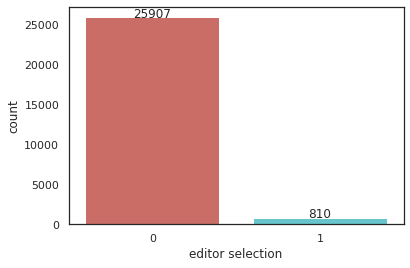

In [322]:
import seaborn as sns
sns.set(style="white")
graph = sns.countplot(x = opinion['editor selection'], data = opinion,palette="hls")
i = 0
for p in graph.patches:
  height = p.get_height()  
  graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        opinion['editor selection'].value_counts()[i],ha="center")
  i += 1
graph.figure
plt.savefig('fig5.eps', bbox_inches='tight')
files.download("fig5.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

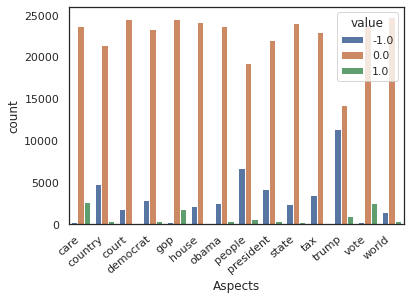

In [320]:
graph2 = sns.countplot(x="variable", hue="value", data=pd.melt(X))
graph2.set_xticklabels(graph2.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Aspects')
plt.figure
plt.savefig('fig6.eps', bbox_inches='tight')
files.download("fig6.eps")

In [352]:
oversample = ADASYN()
X, y = oversample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [354]:
Counter(y)

Counter({0: 25907, 1: 26092})

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=11,stratify=y)

In [161]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [309]:
forest1 = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [355]:
clf1 = LogisticRegression(random_state=0)

In [311]:
scores1 = cross_val_score(forest1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [356]:
scores2 = cross_val_score(clf1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [166]:
from numpy import mean, std

In [315]:
print('Performce of Random Forest: %.3f' % (mean(scores1)))

Performce of Random Forest: 0.750


In [316]:
print('Performance of Logistic Regraression: %.3f' % (mean(scores2)))

Performance of Logistic Regraression: 0.562


In [358]:
y_test_pred1 = forest1.fit(X_train,y_train).predict(X_test)
y_test_pred2 = clf1.fit(X_train,y_train).predict(X_test)

In [207]:
print("Accuracy of test - Random Forest:",metrics.accuracy_score(y_test, y_test_pred1))
print("Accuracy of test - Logistic Regression:",metrics.accuracy_score(y_test, y_test_pred2))

Accuracy of test - Random Forest: 0.7466346153846154
Accuracy of test - Logistic Regression: 0.5605288461538461


In [208]:
target_names = ["0","1"]
print(classification_report(y_test, y_test_pred1, target_names=target_names))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77     10363
           1       0.81      0.64      0.72     10437

    accuracy                           0.75     20800
   macro avg       0.76      0.75      0.74     20800
weighted avg       0.76      0.75      0.74     20800



In [325]:
print(classification_report(y_test, y_test_pred2, target_names=target_names))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56     10363
           1       0.56      0.56      0.56     10437

    accuracy                           0.56     20800
   macro avg       0.56      0.56      0.56     20800
weighted avg       0.56      0.56      0.56     20800



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

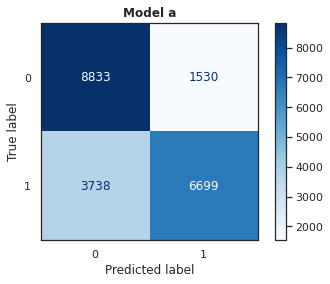

In [335]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(forest1, X_test, y_test, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.plot(cmap=plt.cm.Blues)
plt.title("Model a",fontweight="bold")
plt.figure
plt.savefig('fig1.eps', bbox_inches='tight')
files.download("fig1.eps")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

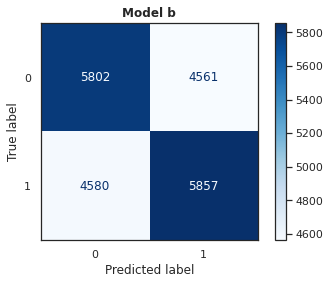

In [336]:
plot_confusion_matrix(clf1, X_test, y_test, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.plot(cmap=plt.cm.Blues)
plt.title("Model b",fontweight="bold")
plt.figure
plt.savefig('fig2.eps', bbox_inches='tight')
files.download("fig2.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

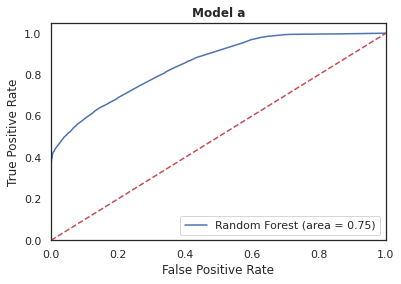

In [340]:
forest_roc_auc = roc_auc_score(y_test, forest1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, forest1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model a",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig7.eps', bbox_inches='tight')
files.download("fig7.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

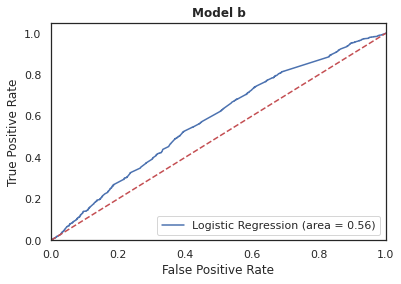

In [360]:
logit_roc_auc = roc_auc_score(y_test, clf1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model b",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig8.eps', bbox_inches='tight')
files.download("fig8.eps")

In [177]:
X_c = np.zeros([51999, 28])

In [178]:
# dummy
for j in range(51999):
  for i in range(14):
    ii = 2*i
    if X[j,i] == 1:
      X_c[j,ii] = 1
    if X[j,i] == -1:
      X_c[j,ii+1] = 1

In [179]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y,test_size=0.4,random_state=11,stratify=y)

In [212]:
forest2 = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [213]:
clf2 = LogisticRegression(random_state=0)

In [214]:
scores3 = cross_val_score(forest2, X_train_c, y_train_c, scoring='accuracy', cv=cv, n_jobs=-1)

In [215]:
scores4 = cross_val_score(clf2, X_train_c, y_train_c, scoring='accuracy', cv=cv, n_jobs=-1)

In [323]:
print('Performce of Random Forest: %.3f' % (mean(scores3)))

Performce of Random Forest: 0.676


In [324]:
print('Performance of Logistic Regraression: %.3f' % (mean(scores4)))

Performance of Logistic Regraression: 0.592


In [218]:
y_test_pred3 = forest2.fit(X_train_c,y_train_c).predict(X_test_c)
y_test_pred4 = clf2.fit(X_train_c,y_train_c).predict(X_test_c)

In [185]:
print("Accuracy of test - Random Forest:",metrics.accuracy_score(y_test_c, y_test_pred3))
print("Accuracy of test - Logistic Regression:",metrics.accuracy_score(y_test_c, y_test_pred4))

Accuracy of test - Random Forest: 0.6715384615384615
Accuracy of test - Logistic Regression: 0.6004807692307692


In [219]:
print(classification_report(y_test_c, y_test_pred3, target_names=target_names))

              precision    recall  f1-score   support

           0       0.75      0.51      0.61     10363
           1       0.63      0.83      0.72     10437

    accuracy                           0.67     20800
   macro avg       0.69      0.67      0.66     20800
weighted avg       0.69      0.67      0.66     20800



In [220]:
print(classification_report(y_test_c, y_test_pred4, target_names=target_names))

              precision    recall  f1-score   support

           0       0.63      0.47      0.54     10363
           1       0.58      0.73      0.65     10437

    accuracy                           0.60     20800
   macro avg       0.61      0.60      0.59     20800
weighted avg       0.61      0.60      0.59     20800



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

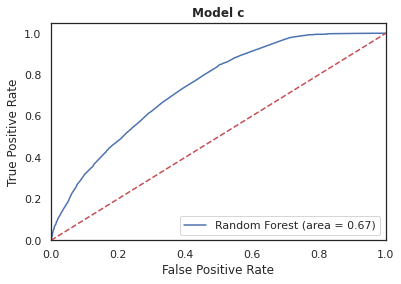

In [361]:
forest_roc_auc = roc_auc_score(y_test_c, forest2.predict(X_test_c))
fpr, tpr, thresholds = roc_curve(y_test_c, forest2.predict_proba(X_test_c)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model c",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig9.eps', bbox_inches='tight')
files.download("fig9.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

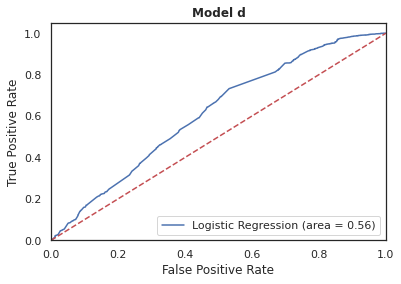

In [362]:
lr_roc_auc = roc_auc_score(y_test_c, clf2.predict(X_test_c))
fpr, tpr, thresholds = roc_curve(y_test_c, clf.predict_proba(X_test_c)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("Model d",fontweight="bold")
plt.legend(loc="lower right")
plt.figure
plt.savefig('fig10.eps', bbox_inches='tight')
files.download("fig10.eps")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

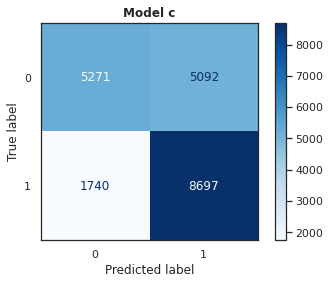

In [338]:
plot_confusion_matrix(forest, X_test_c, y_test_c, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.plot(cmap=plt.cm.Blues)
plt.title("Model c",fontweight="bold")
plt.figure
plt.savefig('fig3.eps', bbox_inches='tight')
files.download("fig3.eps")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

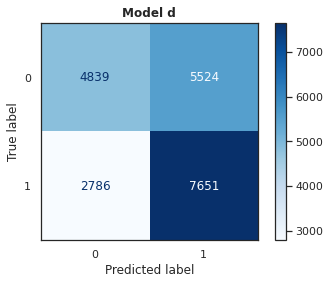

In [337]:
plot_confusion_matrix(clf, X_test_c, y_test_c, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.plot(cmap=plt.cm.Blues)
plt.title("Model d",fontweight="bold")
plt.figure
plt.savefig('fig4.eps', bbox_inches='tight')
files.download("fig4.eps")